# 1-1,结构化数据建模流程范例

In [33]:
import os

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [34]:
!pip install torch
!pip install -U torchkeras

In [35]:
import torch
import torchkeras

print("torch.__version__ = ", torch.__version__)
print("torchkeras.__version__ = ", torchkeras.__version__)

torch.__version__ =  2.0.1
torchkeras.__version__ =  3.9.3


### 一，准备数据

titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

结构化数据一般会使用Pandas中的DataFrame进行预处理。


In [36]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
from torch import nn # 导入神经网络包
from torch.utils.data import Dataset,DataLoader,TensorDataset

dftrain_raw = pd.read_csv('./eat_pytorch_datasets/titanic/train.csv')
dftest_raw = pd.read_csv('./eat_pytorch_datasets/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


字段说明：

* Survived:0代表死亡，1代表存活【y标签】
* Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
* Name:乘客姓名 【舍去】
* Sex:乘客性别 【转换成bool特征】
* Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
* SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
* Parch:乘客父母/孩子的个数(整数值)【数值特征】
* Ticket:票号(字符串)【舍去】
* Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
* Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
* Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】


利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）。

label分布情况

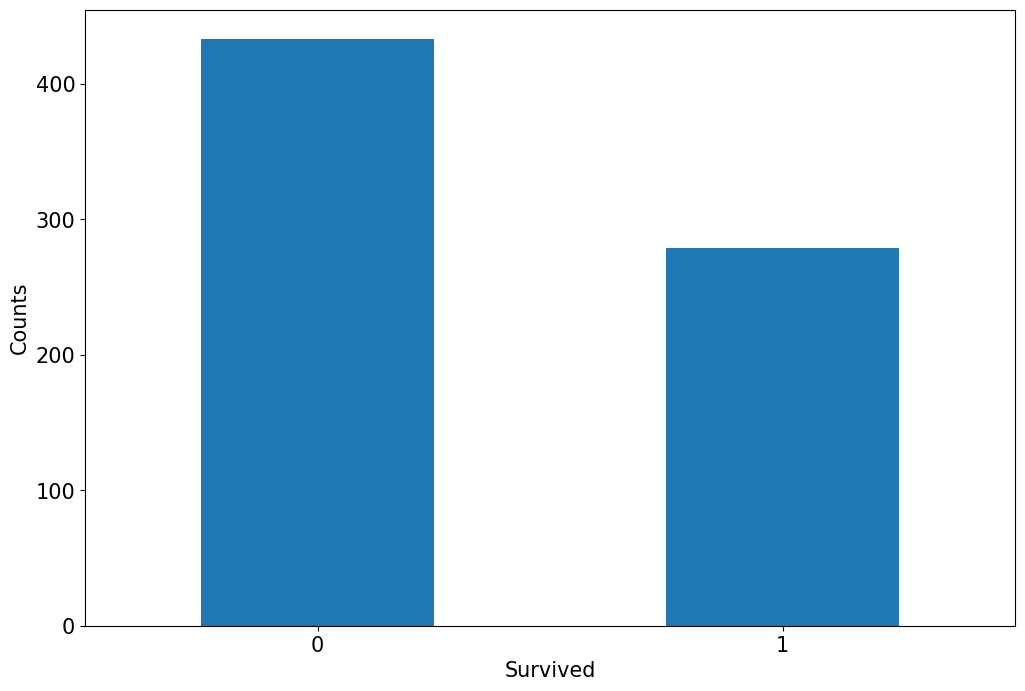

In [37]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# 从DataFrame中获取'Survived'列的值计数，并绘制柱状图
# kind='bar'表示绘制柱状图，figsize=(12, 8)设置图形大小，fontsize=15设置字体大小，rot=0表示不旋转X轴标签
ax = dftrain_raw['Survived'].value_counts().plot(kind='bar',
                                                 figsize=(12, 8), fontsize=15, rot=0)
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('Survived', fontsize=15)
plt.show()


年龄分布情况

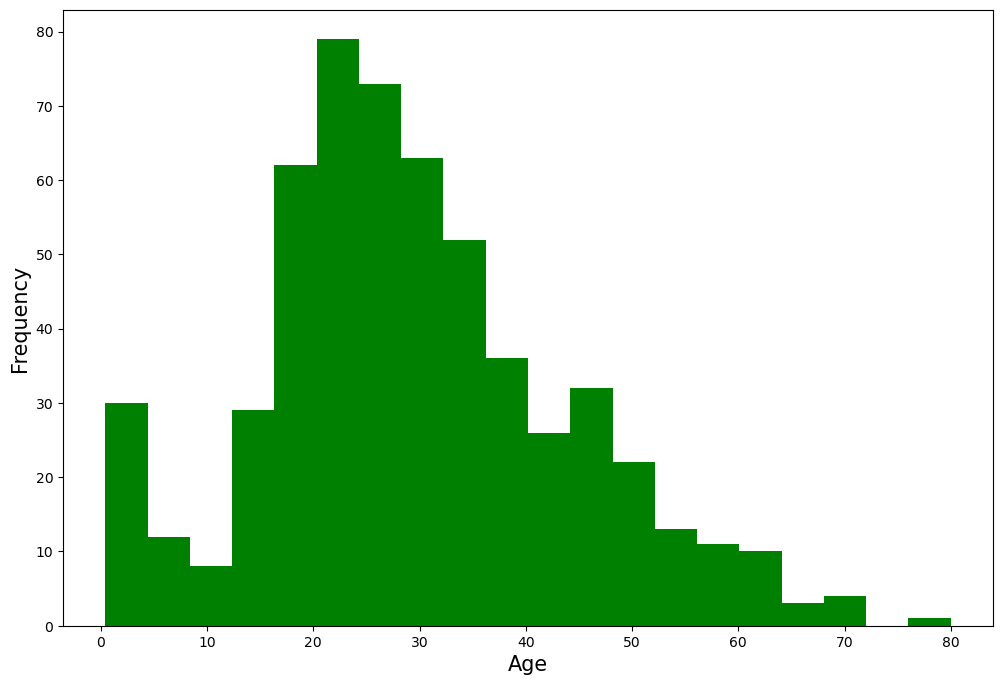

In [38]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# 从数据框（DataFrame）中选择 'Age' 列，并绘制直方图
ax = dftrain_raw['Age'].plot(kind='hist',  # 使用直方图绘制
                             bins=20,  # 将数据分成20个区间
                             color='green',  # 设置直方图的颜色为紫色
                             figsize=(12, 8),  # 设置图的尺寸为12x8英寸
                             fontsize=10)  # 设置字体大小为15

# 设置y轴标签
ax.set_ylabel('Frequency', fontsize=15)  # 设置y轴标签为'Frequency'，字体大小为15

# 设置x轴标签
ax.set_xlabel('Age', fontsize=15)  # 设置x轴标签为'Age'，字体大小为15

# 显示绘制的图形
plt.show()

年龄和label的相关性

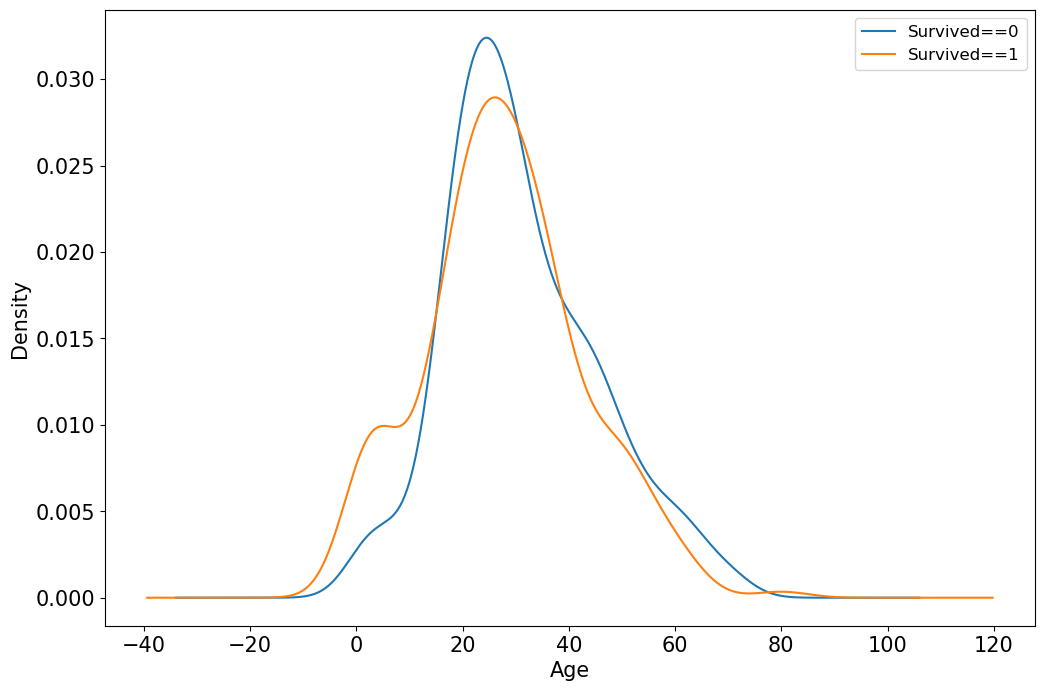

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# 从数据框（DataFrame）中筛选 'Survived' 列等于 0 的数据，并绘制年龄（'Age'）的密度图
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind='density',  # 使用密度图绘制
                                                    figsize=(12, 8),  # 设置图的尺寸为12x8英寸
                                                    fontsize=15)  # 设置字体大小为15

# 从数据框中筛选 'Survived' 列等于 1 的数据，并绘制年龄的密度图
dftrain_raw.query('Survived == 1')['Age'].plot(kind='density',  # 使用密度图绘制
                                               figsize=(12, 8),  # 设置图的尺寸为12x8英寸
                                               fontsize=15)  # 设置字体大小为15

# 添加图例，用于区分 Survived==0 和 Survived==1 的密度图
ax.legend(['Survived==0', 'Survived==1'], fontsize=12)

# 设置y轴标签
ax.set_ylabel('Density', fontsize=15)  # 设置y轴标签为'Density'，字体大小为15

# 设置x轴标签
ax.set_xlabel('Age', fontsize=15)  # 设置x轴标签为'Age'，字体大小为15

# 显示绘制的图形
plt.show()

**下面为正式的数据预处理**

1. `dfPclass = pd.get_dummies(dfdata['Pclass'])`：
   - `pd.get_dummies` 是 Pandas 库中的一个函数，用于进行独热编码。它将具有多个不同取值的分类变量（如 'Pclass' 列）转换为多个二进制（0或1）的列，以便更好地用于机器学习模型。
   - `dfdata['Pclass']` 表示从名为 `dfdata` 的数据框中选择 'Pclass' 列，并将其传递给 `pd.get_dummies` 函数。
   - 结果是一个包含独热编码后数据的新数据框 `dfPclass`。

2. `dfPclass.columns = ['Pclass_' + str(x) for x in dfPclass.columns]`：
   - 这一行代码用于更改 `dfPclass` 数据框的列名。
   - `dfPclass.columns` 返回 `dfPclass` 数据框的列标签。
   - `['Pclass_' + str(x) for x in dfPclass.columns]` 是一个列表推导式，用于将每个列标签都修改为以 'Pclass_' 作为前缀，以便更好地标识这些列。

3. `dfresult = pd.concat([dfresult, dfPclass], axis=1)`：
   - 这一行代码使用 `pd.concat` 函数将 `dfPclass` 数据框与之前的结果数据框 `dfresult` 水平连接（按列连接）。
   - `axis=1` 参数表示按列连接，因此将 `dfPclass` 的列添加到 `dfresult` 中。
   - 这样，`dfresult` 数据框就包含了 'Pclass' 列的独热编码结果，其中每个不同的 'Pclass' 取值都成为了新的列，列名以 'Pclass_' 为前缀。


1. `dfresult['Age'] = dfdata['Age'].fillna(0)`：
   - `dfdata['Age']` 表示从数据框 `dfdata` 中选择 'Age' 列的数据。
   - `dfdata['Age'].fillna(0)` 用于将 'Age' 列中的缺失值（NaN，Not a Number）替换为 0。这意味着如果某一行的 'Age' 列数据缺失（为 NaN），则在 `dfresult` 数据框中相应的位置会填充为 0。这是一种处理缺失值的方法，将缺失值替换为一个特定的数值。

2. `dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')`：
   - `pd.isna(dfdata['Age'])` 用于检查 'Age' 列中哪些值是缺失值。返回的结果是一个布尔型的 Series，其中缺失值对应的位置为 True，非缺失值对应的位置为 False。
   - `.astype('int32')` 用于将布尔型的 Series 转换为整数型的 Series，将 True 转换为 1，将 False 转换为 0。
   - 最终将转换后的整数型 Series 存储在 `dfresult` 数据框中的 'Age_null' 列中。这一列的值表示对应行的 'Age' 是否为缺失值，是缺失值则为 1，否则为 0。

In [40]:
# 定义数据预处理函数
def preprocessing(dfdata):
    dfresult = pd.DataFrame()  # 创建一个空的数据框来存储处理后的数据

    # 处理 'Pclass' 列，将其转换成独热编码
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' + str(x) for x in dfPclass.columns]  # 为每个编码列添加前缀 'Pclass_'
    dfresult = pd.concat([dfresult, dfPclass], axis=1)  # 将编码后的列与结果数据框合并

    # 处理 'Sex' 列，将其转换成独热编码
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult, dfSex], axis=1)  # 将编码后的列与结果数据框合并

    # 处理 'Age' 列，将缺失值用 0 填充，并添加一个新列 'Age_null' 以表示是否有缺失值
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')  # 将缺失值转换为 0 和 1

    # 处理 'SibSp', 'Parch', 'Fare' 列，直接将它们加入结果数据框
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    # 处理 'Cabin' 列，添加一个新列 'Cabin_null' 表示是否有缺失值
    dfresult['Cabin_null'] = pd.isna(dfdata['Cabin']).astype('int32')

    # 处理 'Embarked' 列，将其转换成独热编码
    dfEmbarked = pd.get_dummies(dfdata['Embarked'], dummy_na=True)  # 使用dummy_na=True来处理缺失值
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]  # 为每个编码列添加前缀 'Embarked_'
    dfresult = pd.concat([dfresult, dfEmbarked], axis=1)  # 将编码后的列与结果数据框合并

    return dfresult  # 返回处理后的数据框


# 调用数据预处理函数，将训练集和测试集进行预处理
x_train = preprocessing(dftrain_raw).values  # 将处理后的数据转换为NumPy数组
y_train = dftrain_raw[['Survived']].values  # 获取训练集的标签

x_test = preprocessing(dftest_raw).values  # 将处理后的数据转换为NumPy数组
y_test = dftest_raw[['Survived']].values  # 获取测试集的标签

# 输出数据集的形状信息
print("x_train.shape =", x_train.shape)  # 输出训练集特征矩阵的形状
print("x_test.shape =", x_test.shape)  # 输出测试集特征矩阵的形状
print("y_train.shape =", y_train.shape)  # 输出训练集标签的形状
print("y_test.shape =", y_test.shape)  # 输出测试集标签的形状


x_train.shape = (712, 15)
x_test.shape = (179, 15)
y_train.shape = (712, 1)
y_test.shape = (179, 1)


进一步使用DataLoader和TensorDataset封装成可以迭代的数据管道。

In [41]:
# 创建训练数据加载器 dl_train
dl_train = DataLoader(
    TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float()),  # 使用TensorDataset包装训练数据
    shuffle=True,  # 随机洗牌训练数据，以增加训练的随机性
    batch_size=8  # 设置每个小批量的大小为8
)

# 创建验证数据加载器 dl_val
dl_val = DataLoader(
    TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float()),  # 使用TensorDataset包装验证数据
    shuffle=False,  # 不洗牌验证数据，以确保验证结果的可重复性
    batch_size=8  # 设置每个小批量的大小为8，与训练时一致
)


In [42]:
# 迭代训练数据加载器 dl_train 中的数据批次
for features, labels in dl_train:
    print("Features:", features)  # 打印当前数据批次的特征
    print("Labels:", labels)  # 打印当前数据批次的标签
    break  # 使用 break 语句来退出循环，只打印第一个数据批次


Features: tensor([[ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 14.0000,  0.0000,  4.0000,
          1.0000, 39.6875,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000, 34.0000,  0.0000,  1.0000,
          0.0000, 26.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  1.0000, 27.0000,  0.0000,  0.0000,
          0.0000, 76.7292,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000, 13.0000,  0.0000,  0.0000,
          0.0000,  7.2292,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  3.0000,  0.0000,  3.0000,
          1.0000, 21.0750,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  8.0000,  0.0000,  0.0000,
          2.0000, 26.2500,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 26.0000,  0.

### 二，定义模型

使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器进行封装。

此处选择使用最简单的nn.Sequential，按层顺序模型。

In [43]:
# 定义创建神经网络的函数
def create_net():
    net = nn.Sequential()  # 创建一个Sequential容器，用于按顺序堆叠神经网络的层次

    # 添加第一个全连接层，输入特征数为15，输出特征数为20
    net.add_module("linear1", nn.Linear(15, 20))
    net.add_module("relu1", nn.ReLU())  # 添加ReLU激活函数

    # 添加第二个全连接层，输入特征数为20，输出特征数为15
    net.add_module("linear2", nn.Linear(20, 15))
    net.add_module("relu2", nn.ReLU())  # 添加ReLU激活函数

    # 添加第三个全连接层，输入特征数为15，输出特征数为1，用于二元分类
    net.add_module("linear3", nn.Linear(15, 1))

    return net


# 调用创建神经网络的函数，创建一个名为net的神经网络模型
net = create_net()

# 打印神经网络的结构
print(net)


Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
)


### 三，训练模型

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处介绍一种较通用的仿照Keras风格的脚本形式的训练循环。

该脚本形式的训练代码与 torchkeras 库的核心代码基本一致。

torchkeras详情:  https://github.com/lyhue1991/torchkeras 

以下是代码中计算指标部分的详细说明：

在这部分代码中，首先将神经网络模型切换到训练模式，然后迭代训练数据加载器 (`dl_train`) 中的数据批次。以下是详细说明：

- `net.train()`: 设置神经网络模型为训练模式，这一步是为了激活训练中使用的一些特定功能，例如Dropout层和Batch Normalization层中的训练模式。

- `total_loss` 和 `step`: 用于累积每个数据批次的损失值和迭代次数。

- `loop`: 使用 tqdm 库创建一个迭代器，用于显示训练进度，并通过 `enumerate` 函数遍历训练数据加载器中的数据批次。`total` 参数用于设置迭代的总次数。

- `train_metrics_dict`: 用深拷贝 (`deepcopy`) 创建一个字典，其中包含了用于存储本轮训练过程中评估指标的对象。

- 在每个数据批次的迭代中，进行以下操作：
    - `features` 和 `labels`: 从当前数据批次中获取特征和标签。

    - 前向传播 (`preds = net(features)`)：将特征输入神经网络，获得预测值 `preds`。

    - 计算损失值 (`loss = loss_fn(preds, labels)`)：使用预测值和真实标签计算损失值，这里使用的损失函数是二元交叉熵损失函数。

    - 反向传播 (`loss.backward()`)：根据损失值计算梯度并反向传播，以便更新神经网络的参数。

    - 优化器步骤 (`optimizer.step()`)：根据计算的梯度更新模型参数。

    - 优化器梯度清零 (`optimizer.zero_grad()`)：清零优化器中的梯度，准备处理下一个数据批次。

    - 计算并记录训练指标 (`step_metrics`)：使用评估指标对象计算并记录每个数据批次的训练指标，例如准确度。

    - 记录当前数据批次的损失值和指标，并更新 `total_loss` 和 `step`。

    - 使用 `tqdm` 更新进度条信息，显示当前数据批次的损失值和指标。

- 在每个 epoch 结束时，计算并记录整个 epoch 的平均损失值和指标，并将其添加到 `history` 字典中。

- 最后，重置评估指标对象的状态，以准备处理下一个 epoch。


In [44]:
# 导入必要的库
import sys
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm

import torch
from torch import nn
from copy import deepcopy
from torchkeras.metrics import Accuracy  # 导入自定义指标Accuracy


# 定义一个打印日志信息的函数
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n" + "==========" * 8 + "%s" % nowtime)
    print(str(info) + "\n")


# 使用二元交叉熵损失函数创建损失函数对象
loss_fn = nn.BCEWithLogitsLoss()

# 使用Adam优化器进行模型参数的优化，学习率为0.01
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# 定义一个字典，用于存储模型评估指标，这里包括准确度
metrics_dict = {"acc": Accuracy()}

# 训练的总轮数
epochs = 20

# 定义用于保存最佳模型权重的文件路径
ckpt_path = 'checkpoint.pt'

# Early Stopping 相关设置
monitor = "val_acc"  # 用于监控模型性能的指标
patience = 5  # 当连续多少轮性能没有提升时，触发早停
mode = "max"  # 监控指标的模式，"max"表示监控指标越大越好

# 存储训练历史信息的字典
history = {}

# 开始训练循环
for epoch in range(1, epochs + 1):
    printlog("Epoch {0} / {1}".format(epoch, epochs))

    # 1，训练阶段 -------------------------------------------------
    net.train()  # 设置模型为训练模式

    total_loss, step = 0, 0

    # 使用tqdm库显示训练进度，并设置文件输出为sys.stdout
    loop = tqdm(enumerate(dl_train), total=len(dl_train), file=sys.stdout)
    train_metrics_dict = deepcopy(metrics_dict)  # 复制评估指标字典，用于存储本轮训练的指标值

    for i, batch in loop:

        features, labels = batch
        # 前向传播
        preds = net(features)
        loss = loss_fn(preds, labels)

        # 反向传播
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # 计算指标
        step_metrics = {"train_" + name: metric_fn(preds, labels).item()
                        for name, metric_fn in train_metrics_dict.items()}

        # 创建包含本步骤的训练损失和指标的字典
        step_log = dict({"train_loss": loss.item()}, **step_metrics)

        total_loss += loss.item()

        step += 1
        if i != len(dl_train) - 1:
            loop.set_postfix(**step_log)
        else:
            # 如果是本轮的最后一个批次，计算本轮的平均训练损失
            epoch_loss = total_loss / step

            # 计算并记录本轮的平均训练指标
            epoch_metrics = {"train_" + name: metric_fn.compute().item()
                             for name, metric_fn in train_metrics_dict.items()}

            # 创建包含本轮的平均训练损失和指标的字典
            epoch_log = dict({"train_loss": epoch_loss}, **epoch_metrics)

            # 更新进度条的显示，显示本轮的平均训练损失和指标
            loop.set_postfix(**epoch_log)

            # 重置本轮的训练指标，以便下一轮使用
            for name, metric_fn in train_metrics_dict.items():
                metric_fn.reset()

    # 将本轮的训练损失和指标记录到训练历史中
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]

    # 2，验证阶段 -------------------------------------------------
    net.eval()  # 设置模型为评估模式

    total_loss, step = 0, 0
    loop = tqdm(enumerate(dl_val), total=len(dl_val), file=sys.stdout)

    val_metrics_dict = deepcopy(metrics_dict)  # 复制评估指标字典，用于存储本轮验证的指标值

    with torch.no_grad():  # 不计算梯度
        for i, batch in loop:

            features, labels = batch

            # 前向传播
            preds = net(features)
            loss = loss_fn(preds, labels)

            # 计算指标
            step_metrics = {"val_" + name: metric_fn(preds, labels).item()
                            for name, metric_fn in val_metrics_dict.items()}

            # 创建包含本步骤的验证损失和指标的字典
            step_log = dict({"val_loss": loss.item()}, **step_metrics)

            total_loss += loss.item()
            step += 1
            if i != len(dl_val) - 1:
                loop.set_postfix(**step_log)
            else:
                # 如果是本轮的最后一个批次，计算本轮的平均验证损失
                epoch_loss = (total_loss / step)

                # 计算并记录本轮的平均验证指标
                epoch_metrics = {"val_" + name: metric_fn.compute().item()
                                 for name, metric_fn in val_metrics_dict.items()}

                # 创建包含本轮的平均验证损失和指标的字典
                epoch_log = dict({"val_loss": epoch_loss}, **epoch_metrics)

                # 更新进度条的显示，显示本轮的平均验证损失和指标
                loop.set_postfix(**epoch_log)

                # 重置本轮的验证指标，以便下一轮使用
                for name, metric_fn in val_metrics_dict.items():
                    metric_fn.reset()

    # 将本轮的验证损失和指标记录到训练历史中
    epoch_log["epoch"] = epoch
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]

    # 3，Early Stopping -------------------------------------------------
    arr_scores = history[monitor]  # 获取历史上的监控指标数值
    best_score_idx = np.argmax(arr_scores) if mode == "max" else np.argmin(arr_scores)

    # 如果当前的模型性能比历史上的最佳性能好，保存当前模型权重
    if best_score_idx == len(arr_scores) - 1:
        torch.save(net.state_dict(), ckpt_path)
        print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
                                                          arr_scores[best_score_idx]), file=sys.stderr)

    # 如果连续多轮性能没有提升，触发早停
    if len(arr_scores) - best_score_idx > patience:
        print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
            monitor, patience), file=sys.stderr)
        break

    # 恢复历史上的最佳模型权重
    net.load_state_dict(torch.load(ckpt_path))

# 将训练历史信息转为DataFrame格式
dfhistory = pd.DataFrame(history)



================================================================================2023-09-02 21:37:20
Epoch 1 / 20

100%|██████████| 23/23 [00:00<00:00, 374.15it/s, val_acc=0.626, val_loss=0.627]

<<<<<< reach best val_acc : 0.6256983280181885 >>>>>>




================================================================================2023-09-02 21:37:20
Epoch 2 / 20

100%|██████████| 23/23 [00:00<00:00, 461.26it/s, val_acc=0.793, val_loss=0.46]

<<<<<< reach best val_acc : 0.7932960987091064 >>>>>>




================================================================================2023-09-02 21:37:20
Epoch 3 / 20

100%|██████████| 23/23 [00:00<00:00, 470.60it/s, val_acc=0.698, val_loss=0.581]

================================================================================2023-09-02 21:37:21
Epoch 4 / 20

100%|██████████| 23/23 [00:00<00:00, 470.60it/s, val_acc=0.793, val_loss=0.46]

================================================================================2023-09-02 21:37:21
Epoch 5 / 20

100%|██████████| 23/23 [00:00<00:00, 470.63it/s, val_acc=0.765, val_loss=0.445]

================================================================================2023-09-02 21:37:22
Epoch 6 / 20

100%|██████████| 23/23 [00:00<00:00, 490.65it/s, val_acc=0.782, val_loss=0.52]

================================================================================2023-09-02 21:37:22
Epoch 7 / 20

100%|██████████| 23/23 [00:00<00:00, 549.09it/s, val_acc=0.704, val_loss=0.583]


<<<<<< val_acc without improvement in 5 epoch, early stopping >>>>>>


### 四，评估模型

我们首先评估一下模型在训练集和验证集上的效果。

In [45]:
dfhistory

,train_loss,train_acc,val_loss,val_acc,epoch
0,0.640475,0.650281,0.627165,0.625698,1
1,0.554092,0.716292,0.459909,0.793296,2
2,0.523918,0.761236,0.581057,0.698324,3
3,0.534845,0.741573,0.460333,0.793296,4
4,0.509438,0.775281,0.445144,0.765363,5
5,0.508597,0.787921,0.520414,0.782123,6
6,0.515445,0.769663,0.583498,0.703911,7


In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'  # 指定绘图格式为SVG

import matplotlib.pyplot as plt


# 定义一个函数，用于绘制训练和验证指标曲线
def plot_metric(dfhistory, metric):
    # 从训练历史数据中获取训练和验证指标的数值
    train_metrics = dfhistory["train_" + metric]
    val_metrics = dfhistory['val_' + metric]
    # 创建一个表示轮次的范围
    epochs = range(1, len(train_metrics) + 1)
    # 绘制训练指标曲线，使用蓝色圆点形状的线条
    plt.plot(epochs, train_metrics, 'bo--')
    # 绘制验证指标曲线，使用红色实线的线条
    plt.plot(epochs, val_metrics, 'ro-')
    # 设置图表标题
    plt.title('Training and validation ' + metric)
    # 设置X轴标签
    plt.xlabel("Epochs")
    # 设置Y轴标签
    plt.ylabel(metric)
    # 添加图例，表示训练和验证指标对应的线条
    plt.legend(["train_" + metric, 'val_' + metric])
    # 显示图表
    plt.show()


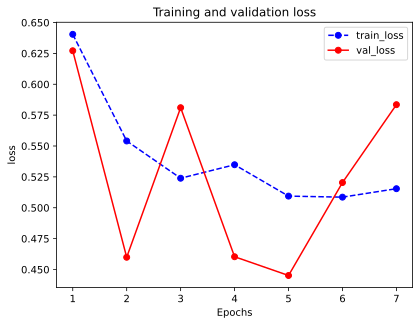

In [47]:
plot_metric(dfhistory, "loss")

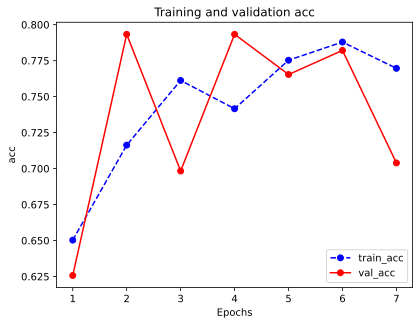

In [48]:
plot_metric(dfhistory, "acc")

### 五，使用模型

In [49]:
# 使用神经网络进行推断，计算前10个样本的预测概率
# 使用 torch.sigmoid 函数将模型输出的 logits 转换为概率值

y_pred_probs = torch.sigmoid(
    net(torch.tensor(x_test[0:10]).float())  # 将前10个测试样本转换为 PyTorch 张量并进行推断
).data

# 输出预测概率值
y_pred_probs


tensor([[0.0890],
        [0.4536],
        [0.3001],
        [0.3704],
        [0.5463],
        [0.5544],
        [0.0763],
        [0.5896],
        [0.2655],
        [0.1236]])

In [50]:
# 预测类别
# 如果预测的概率值大于0.5，则将类别设置为1，否则设置为0

# 使用 torch.where 函数进行类别的判定
y_pred = torch.where(
    y_pred_probs > 0.5,  # 预测概率值大于0.5时，为正类别
    torch.ones_like(y_pred_probs),  # 正类别标签（1）
    torch.zeros_like(y_pred_probs)  # 负类别标签（0）
)

# 输出预测的类别
y_pred


tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.]])

### 六，保存模型

Pytorch 有两种保存模型的方式，都是通过调用pickle序列化方法实现的。

第一种方法只保存模型参数。

第二种方法保存完整模型。

推荐使用第一种，第二种方法可能在切换设备和目录的时候出现各种问题。


**1，保存模型参数(推荐)**

In [51]:
# 打印神经网络模型的状态字典中的所有键
print(net.state_dict().keys())

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


In [52]:
# 保存模型参数到文件 "./data/net_parameter.pt"
torch.save(net.state_dict(), "./data/net_parameter.pt")

# 创建一个新的神经网络模型 net_clone
net_clone = create_net()

# 加载保存的模型参数到 net_clone
net_clone.load_state_dict(torch.load("./data/net_parameter.pt"))

# 对前10个测试样本进行推断，使用新的模型 net_clone
# 使用 torch.sigmoid 函数将模型输出的 logits 转换为概率值
predictions = torch.sigmoid(net_clone.forward(torch.tensor(x_test[0:10]).float())).data

# 输出预测的概率值
predictions


tensor([[0.0890],
        [0.4536],
        [0.3001],
        [0.3704],
        [0.5463],
        [0.5544],
        [0.0763],
        [0.5896],
        [0.2655],
        [0.1236]])

**2，保存完整模型(不推荐)**

In [53]:
# 保存整个神经网络模型到文件 "./data/net_model.pt"
torch.save(net, './data/net_model.pt')

# 加载整个神经网络模型
net_loaded = torch.load('./data/net_model.pt')

# 对前10个测试样本进行推断，使用加载的模型 net_loaded
# 使用 torch.sigmoid 函数将模型输出的 logits 转换为概率值
predictions = torch.sigmoid(net_loaded(torch.tensor(x_test[0:10]).float())).data

# 输出预测的概率值
predictions


tensor([[0.0890],
        [0.4536],
        [0.3001],
        [0.3704],
        [0.5463],
        [0.5544],
        [0.0763],
        [0.5896],
        [0.2655],
        [0.1236]])

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)